In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import urllib
import glob
import os
import time
from PIL import Image

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# load dataset
df = pd.read_json(r'/content/drive/MyDrive/projects/500_projects/number plate detection/Indian_Number_plates.json',lines=True)
print(df.shape)
df.head()


(237, 3)


,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


The dataset I am using here is in JSON format with multiline records. The two main elements are content and annotation. The content contains links to images and an annotation contains information about the respected image.

I wrote a simple script to download and save all images to a directory while saving their respected annotation information in a dictionary. At first, I thought all images were in JPEG format. However, a quick inspection of the uploaded images showed this assumption to be wrong. Some images are in GIF format. So before saving the images, I converted them to JPEG images with three channels (RGB) using the PIL library in Python:

In [2]:
df.annotation[0]

[{'imageHeight': 466,
  'imageWidth': 806,
  'label': ['number_plate'],
  'notes': '',
  'points': [{'x': 0.722084367245657, 'y': 0.5879828326180251},
   {'x': 0.8684863523573201, 'y': 0.688841201716738}]}]

In [4]:
if not os.path.exists('/content/Indian_number_plates'): # creating direcotory where i will save my downloaded images
  os.makedirs('Indian_number_plates') 
dataset=dict()
dataset['image_name']=list()
dataset['image_width']=list()
dataset['image_height']=list()
dataset['top_x']=list()
dataset['top_y']=list()
dataset['bottom_x']=list()
dataset['bottom_y']=list()

counter=0
for index,row in df.iterrows():
  img = urllib.request.urlopen(row['content'])
  img = Image.open(img)
  img = img.convert('RGB')
  img.save(f"Indian_number_plates/licensed_car{counter}.jpeg","JPEG")

  dataset['image_name'].append(f"licensed_car{counter}")
  
  data = row["annotation"] # annotation column contains the image data

  dataset['image_width'].append(data[0]['imageWidth'])
  dataset['image_height'].append(data[0]['imageHeight'])
  dataset['top_x'].append(data[0]['points'][0]['x'])
  dataset['top_y'].append(data[0]['points'][0]['y'])
  dataset['bottom_x'].append(data[0]['points'][1]['x'])
  dataset['bottom_y'].append(data[0]['points'][1]['y'])
  counter += 1
  

print(f'Downloaded {counter} car images')


Downloaded 237 car images


In [5]:
df = pd.DataFrame(dataset) # creating dataframe form dataset dictionary
df.head()

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,licensed_car0,806,466,0.722084,0.587983,0.868486,0.688841
1,licensed_car1,494,449,0.161943,0.850780,0.582996,1.000000
2,licensed_car2,500,314,0.082000,0.697452,0.230000,0.828025
3,licensed_car3,500,469,0.434000,0.667377,0.718000,0.765458
4,licensed_car4,1001,563,0.208791,0.390764,0.865135,0.984014


In [6]:
# now i will drop the image_width and image_height columns 
df.drop(['image_width','image_height'],axis=1,inplace=True)

In [7]:
df['image_name'] = df['image_name']+'.jpeg'

In [8]:
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,0.208791,0.390764,0.865135,0.984014


In the code below I have chosen five random records from the dataset for later visual inspection of the predictions. I deleted these records from the original dataframe to prevent the model from being trained on them:

In [11]:
test_samples=df.sample(5)
ndf=df.drop(test_samples.index).reset_index(drop=True)

In [12]:
ndf

,image_name,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,0.208791,0.390764,0.865135,0.984014
...,...,...,...,...,...
227,licensed_car232.jpeg,0.344000,0.609290,0.706000,0.778689
228,licensed_car233.jpeg,0.368000,0.453453,0.616000,0.618619
229,licensed_car234.jpeg,0.334000,0.608434,0.628000,0.768072
230,licensed_car235.jpeg,0.295222,0.601208,0.441980,0.719033


In [13]:
width=224
height=224
channel=3

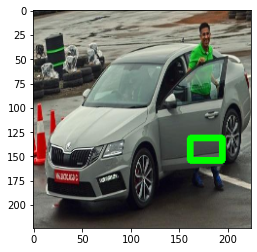

In [18]:
img = cv2.imread("/content/Indian_number_plates/"+ df['image_name'].iloc[2])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,dsize=(width,height))
tx = int(df['top_x'].iloc[0]*width)
ty = int(df['top_y'].iloc[0]*height)
bx = int(df['bottom_x'].iloc[0]*width)
by = int(df['bottom_y'].iloc[0]*height)

img = cv2.rectangle(img,(tx,ty),(bx,by),(0,255,0),5)
plt.imshow(img)

To train the model for Number Plate Detection, I’ll first create an ImageDataGenerator object from Keras to load batches of images into memory. This process is necessary because we do not have infinite memory in RAM and GPU RAM.

Then I will split the data in half with a batch size of 32 images. One for training (80% of data) and one for validation (20% of data) during training. Validation is important to see if the model overfits the training data:

In [19]:
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)

train_gen = datagen.flow_from_dataframe(ndf,
                                        directory='/content/Indian_number_plates',
                                        x_col = 'image_name',
                                        y_col =['top_x','top_y','bottom_x','bottom_y'],
                                        target_size=(width,height),
                                        batch_size=32,
                                        class_mode='raw',
                                        subset='training')


Found 209 validated image filenames.


In [20]:
test_gen = datagen.flow_from_dataframe(
    ndf,
    directory="/content/Indian_number_plates",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(width, height),
    batch_size=32, 
    class_mode="raw",
    subset="validation")

Found 23 validated image filenames.


In [21]:
vgg = VGG16(include_top=False,input_shape=(height,width,channel))

58892288/58889256 [==============================] - 0s 0us/step


In [22]:
for layer in vgg.layers:
  layer.trainable = False

In [23]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [27]:
model = Sequential()
model.add(VGG16(include_top=False,input_shape=(height,width,channel)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 17,938,756
Trainable params: 17,938,756
Non-trainable params: 0
__________________________________________

In [33]:
model.layers[0].trainable=False

In [35]:
train_gen.n

209

In [37]:
model.compile('adam',loss='mse')
model.fit_generator(train_gen,
                    steps_per_epoch = train_gen.n//32,
                    epochs=10,
                    validation_data=test_gen,
                    validation_steps=test_gen.n//32
                    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
6/6 [==============================] - 43s 924ms/step - loss: 0.0923
Epoch 2/10
6/6 [==============================] - 1s 230ms/step - loss: 0.0656
Epoch 3/10
6/6 [==============================] - 1s 234ms/step - loss: 0.0464
Epoch 4/10
6/6 [==============================] - 1s 228ms/step - loss: 0.0462
Epoch 5/10
6/6 [==============================] - 1s 255ms/step - loss: 0.0346
Epoch 6/10
6/6 [==============================] - 1s 204ms/step - loss: 0.0329
Epoch 7/10
6/6 [==============================] - 1s 235ms/step - loss: 0.0362
Epoch 8/10
6/6 [==============================] - 2s 239ms/step - loss: 0.0328
Epoch 9/10
6/6 [==============================] - 2s 250ms/step - loss: 0.0304
Epoch 10/10
6/6 [==============================] - 1s 205ms/step - loss: 0.0287


In [39]:
model.evaluate_generator(test_gen,steps=test_gen.n//32)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[]

In [40]:
test_samples.image_name.iloc[0]

'licensed_car215.jpeg'

In [44]:

img.shape

(448, 500, 3)


(224, 224, 3)

In [45]:


y_hat

array([[1.5891775e-08, 5.7620603e-01, 8.0245519e-01, 8.1447697e-01]],
      dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(448, 500, 3)


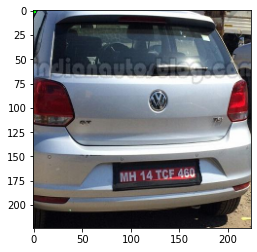

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(959, 959, 3)


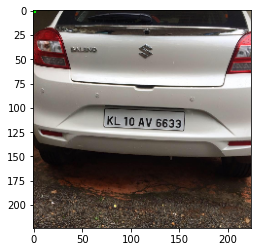

(291, 500, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


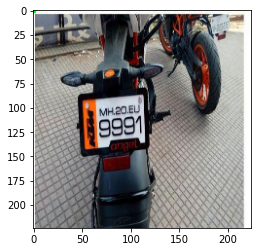

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(769, 1024, 3)


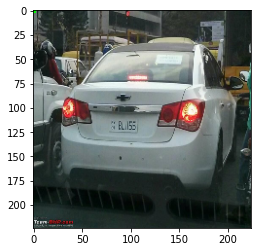

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(456, 484, 3)


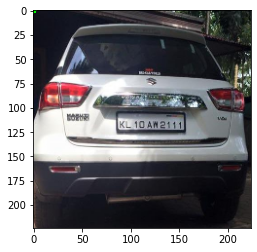

In [51]:
for i in range(len(test_samples)):
  img = cv2.imread('/content/Indian_number_plates/'+test_samples.image_name.iloc[i])
  img = img/255.
  print(img.shape)
  img = cv2.resize(img,(width,height))
  y_hat=model.predict(img.reshape(1,width,height,3))
  xt,yt,xb,yb=y_hat[0][0],y_hat[0][1],y_hat[0][2],y_hat[0][3]
  img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
  image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 255, 0), 5)
  plt.imshow(image)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


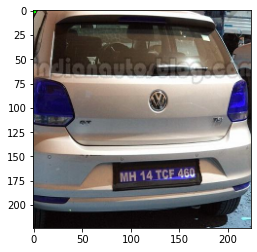